# Encuesta SysArmy: Evolución de salarios del sector en Argentina (2014.02 - 2018.01)

## Datasets

The used datasets have been published on the SysArmy blog since they started taking the surveys.  Each survey contains differencies on their columns, mostly additions across time, but some names and order have changed to.

In order to normalize the different structures, the next section includes a
 couple of functions to facilitate this process.  Below, is the list of datasets used at the moment.

### Salaries

| Period  | Path             | URL                                                                                                         |
|---------|------------------|-------------------------------------------------------------------------------------------------------------|
| 2014.02 | data/2014.02.csv | https://drive.google.com/open?id=0B7UapTwn9AahWkdEWnltRjUwVjQ                                               |
| 2015.01 | data/2015.01.csv | https://drive.google.com/open?id=0B7UapTwn9AahSHl1aGNfTlNrYWc                                               |
| 2016.01 | data/2016.01.csv | https://drive.google.com/open?id=0B7UapTwn9AahLTJmSE5zOUQ0aGc                                               |
| 2016.02 | data/2016.02/    | https://drive.google.com/open?id=0B7UapTwn9AahUGtySFBjdHBCcWs                                               |
| 2017.01 | data/2017.01/    | https://docs.google.com/spreadsheets/d/1diZG7ruHJ4OgO2-tbnO-ZnhjxjOnYjMVSxl7I-4LT54/edit#gid=1424918437     |
| 2017.02 | data/2017.02/    | https://docs.google.com/spreadsheets/d/1f1CAmzbVtoL66IwXJWEf0Mn-QbMNGZIoCQ_b1HB-91E                         |
| 2018.01 | data/2018.01/    | https://docs.google.com/spreadsheets/d/1OcOGeYEsI-iIO_QNfl_8avUK2ifg9wRFUly-f-c1CJM/edit#gid=2144425141 |


The datasets detailed above were downloaded and included "as is" in the `data/` folder on this repository.  The idea of this analysis is to not preprocess anything, and just normalize the data on the fly, of course this is possible given that the datasets are not so big.

### Argentine Peso AR\$ to US\$

In one of the analysis (GDP) we will compare the salaries through time using the dollar as currency of reference. We do this in order to understand the numbers in the global economy, putting aside the effects of inflation.
In relation to the inflation, the official numbers are not so good for an appropiate analysis: between 2014 and 2015 the methodology changed, and it's been an entire year (April 2016 - March 2018) without measurement.

#### Links of interest

* https://es.tradingeconomics.com/argentina/inflation-cpi
* http://data.worldbank.org/indicator/NY.GDP.MKTP.CD?end=2016&locations=AR&start=1962&view=chart

| Period  | Path                 | URL                                                                                                     |
|---------|----------------------|---------------------------------------------------------------------------------------------------------|
| 5Y      | data/usdars-cur.json | https://www.bloomberg.com/markets/api/bulk-time-series/price/USDARS%3ACUR?timeFrame=5_YEAR              |


## Data preparation

In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import cm
from functools import reduce
from IPython.display import display, Markdown as md

def getPeriodDF(period, publish_date, csv_path, columns_src, columns_dst, transforms = []):
    # given a csv_path, extract src columns into dst columns by applying a transform function for a certain period name
    df_src = pd.read_csv(csv_path)
    df_dst = pd.DataFrame(columns=['period', 'publish_date']+columns_dst)
    df_dst[columns_dst] = df_src[columns_src]
    df_dst['period'] = period
    df_dst['publish_date'] = pd.to_datetime(publish_date)
    # apply custom transformations
    for transform in transforms:
        df_src, df_dst = transform(df_src, df_dst)
    return df_dst

def transformNormalize(df_src, df_dst):
    # cast to float the salary column, some datasets gets wrongly parsed due to crappy user input
    df_dst['salary'] = df_dst['salary'].astype(float)
    df_dst['age'] = df_dst['age'].astype(str)
    # normalize stack column
    re_separator = ' *, *| *; *| *\. *| *\| *| *\/ *| *- *'
    re_garbage = '"""|\*|nan|='
    df_dst['stack'] = df_dst['stack'].apply(lambda s: re.split(re_separator, re.sub(re_garbage, '', str(s)).strip().lower()))
    # munge the dataset, removing entries that we consider not realistic for our analysis
    munging_mask = (df_dst.salary > 5000) & (df_dst.salary < 300000)
    df_src = df_src.loc[munging_mask]
    df_dst = df_dst.loc[munging_mask]
    return df_src, df_dst

def transformNet2Brute(df_src, df_dst):
    # filter wether net or brute income
    mask = np.array(df_src['Bruto o neto?'].str.contains('Neto'), dtype = bool)
    net_factor = np.array([1.0] * len(df_dst));
    # scales up net salary into brute, given Argentina's social security contributions
    net_factor[ mask ] = 1/0.83
    df_dst['salary'] = net_factor * df_dst['salary']
    return df_src, df_dst

def transformNet2Brute201702(df_src, df_dst):
    # filter wether net or brute income
    mask = np.array(df_src['¿Porcentaje, bruto o neto?'].str.contains('Neto'), dtype = bool)
    net_factor = np.array([1.0] * len(df_dst));
    # scales up net salary into brute, given Argentina's social security contributions
    net_factor[ mask ] = 1/0.83
    df_dst['salary'] = net_factor * df_dst['salary']
    return df_src, df_dst

src_common_cols = [
    'Tengo',
    'Años de experiencia',
    'Años en el puesto actual',
    'Trabajo de',
    'Tecnologías que utilizás']

dst_cols = [
    'salary',
    'location',
    'age',
    'yoe',
    'yip',
    'role',
    'stack']

df1 = getPeriodDF('2014.02', '2015-01-01', '../../data/2014.02.csv', 
                  ['Salario bruto mensual (AR$)', 'Trabajo en'] + src_common_cols, dst_cols, 
                  [transformNormalize])

df2 = getPeriodDF('2015.01', '2015-09-01', '../../data/2015.01.csv', 
                  ['Salario bruto mensual (AR$)', 'Trabajo en'] + src_common_cols, dst_cols, 
                  [transformNormalize])

df3 = getPeriodDF('2016.01', '2016-02-01', '../../data/2016.01.csv', 
                  ['Salario mensual (AR$)', 'Trabajo en'] + src_common_cols, dst_cols, 
                  [transformNormalize, transformNet2Brute])

df4 = getPeriodDF('2016.02', '2016-08-01', '../../data/2016.02/argentina.csv', 
                  ['Salario mensual (en tu moneda local)', 'Argentina'] + src_common_cols, dst_cols, 
                  [transformNormalize, transformNet2Brute])

df5 = getPeriodDF('2017.01', '2017-02-01', '../../data/2017.01/argentina.csv', 
                  ['Salario mensual (en tu moneda local)', 'Argentina'] + src_common_cols, dst_cols, 
                  [transformNormalize, transformNet2Brute])

df6 = getPeriodDF('2017.02', '2017-09-01', '../../data/2017.02/argentina.csv', 
                  ['Salario mensual (en tu moneda local)', 'Argentina'] + src_common_cols, dst_cols, 
                  [transformNormalize, transformNet2Brute201702])

df7 = getPeriodDF('2018.01', '2018-03-01', '../../data/2018.01/argentina.csv', 
                  ['Salario mensual (en tu moneda local)', 'Argentina'] + src_common_cols, dst_cols, 
                  [transformNormalize, transformNet2Brute201702])

# compute the union of all the datasets as a signe pandas dataframe
df = pd.concat([df1, df2, df3, df4, df5, df6, df7])

# extract the list of periods
periods = df.period.unique()

# extract the list of roles
roles = df.role.unique()

# generate a list of colors by period for easy visualization on next figures
colors = cm.rainbow(np.linspace(0, 1, len(periods)))

# extract the list of stacks
all_stacks = reduce(lambda res, it: np.concatenate((res, it)), df['stack'], np.array([]))
data = np.transpose(np.unique(all_stacks, return_counts=True))
dfs = pd.DataFrame(data, columns=['stack', 'count'])
dfs['count'] = dfs['count'].astype(int)

# extract the list of roles
data = np.transpose(np.unique(df['role'].apply(lambda s: s.strip()), return_counts=True))
dfr = pd.DataFrame(data, columns=['role', 'count'])
dfr['count'] = dfr['count'].astype(int)

# create a dataframe with the most frequent stack names and mask of rows in main df matching it
dfs = dfs.query('count > 100 & stack != ""').sort_values(by=['count'], ascending=[0])
dfs['df_mask'] = dfs['stack'].apply(lambda stack: np.array(df['stack'].apply(lambda s: np.isin(stack, s))))

# create a dataframe with the most frequent role names and mask of rows in main df matching it
dfr = dfr.query('count > 100 & role != ""').sort_values(by=['count'], ascending=[0])
dfr['df_mask'] = dfr['role'].apply(lambda role: np.array(df['role'] == role))

# show results
display(md('# Normalized data'))
display(md('## Survey entries'))
display(df.head())
# we take only the top stacks/roles because the fields were free-text, and this resulted
# in many outliers, ie: random text without continuity for a proper time-series analysis
display(md('## Top stacks: names, frquency and entries mask'))
display(dfs.head())
display(md('## Top roles: names, frquency and entries mask'))
display(dfr.head())

# Normalized data

## Survey entries

,period,publish_date,salary,location,age,yoe,yip,role,stack
0,2014.02,2015-01-01,21000.00,Ciudad Autónoma de Buenos Aires,27 - 30,5 - 7,Menos de un año,SysAdmin,"[linux, cloud]"
1,2014.02,2015-01-01,10000.00,Ciudad Autónoma de Buenos Aires,35 - 40,10+,2 - 4,SysAdmin,[linux]
2,2014.02,2015-01-01,16000.00,Córdoba,27 - 30,3 - 5,1 - 2,DevOps,"[linux, cloud]"
3,2014.02,2015-01-01,23771.13,Ciudad Autónoma de Buenos Aires,27 - 30,5 - 7,1 - 2,SysAdmin,[linux]
4,2014.02,2015-01-01,16000.00,Ciudad Autónoma de Buenos Aires,30 - 33,10+,2 - 4,DevOps,[linux]


## Top stacks: names, frquency and entries mask

,stack,count,df_mask
749,windows,5338,"[False, False, False, False, False, False, Fal..."
336,linux,4421,"[True, True, True, True, True, False, False, F..."
728,vmware,2450,"[False, False, False, False, False, False, Fal..."
127,containers,994,"[False, False, False, False, False, False, Fal..."
160,docker,994,"[False, False, False, False, False, False, Fal..."


## Top roles: names, frquency and entries mask

,role,count,df_mask
592,Developer,7668,"[False, False, False, False, False, False, Fal..."
1754,SysAdmin / DevOps,3435,"[False, False, False, False, False, False, Fal..."
856,HelpDesk,2456,"[False, False, False, False, False, False, Fal..."
1218,Networking,1342,"[False, False, False, False, False, False, Tru..."
1312,PM,944,"[False, False, False, False, False, True, Fals..."


In [2]:
import scipy.stats as sps
import matplotlib.pyplot as plt

def getPlotSalarySeries(currencySeries):
    s = currencySeries.apply(lambda x: float('{0:.2f}'.format(round(x/1000, 1))))
    mu, sigma = np.mean(s), np.std(s)
    median = np.median(s)
    t = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
    d = sigma**2/mu
    return mu, sigma, t, d, median, s


dfrt = pd.DataFrame(columns=['role', 'count', 'mu', 'sigma', 'period', 'publish_date'])

i = 0
for period in periods:
    for j, row in dfr.iterrows():
        dfrs = df.loc[ row['df_mask'] & (df['period'] == period) ]
        if len(dfrs) == 0: continue
        mu, sigma, t, d, m, s = getPlotSalarySeries(dfrs['salary'])
        dfrt.loc[i] = [row['role'], len(dfrs), mu, sigma, period, np.max(dfrs['publish_date'])]
        i = i+1

# the ranking of technologies most frequent in the datasets order by mean of salary
dfrt = dfrt.query('count > 1').sort_values(by=['role', 'period'], ascending=[0, 0])
display(md('## Top roles: numbers by period'))
dfrt.head()

## Top roles: numbers by period

,role,count,mu,sigma,period,publish_date
71,SysAdmin / DevOps,530.0,40.315849,23.088797,2018.01,2018-03-01
59,SysAdmin / DevOps,639.0,34.385915,15.772861,2017.02,2017-09-01
47,SysAdmin / DevOps,640.0,28.695000,14.261597,2017.01,2017-02-01
35,SysAdmin / DevOps,636.0,24.607075,11.653473,2016.02,2016-08-01
23,SysAdmin / DevOps,990.0,20.572828,13.491941,2016.01,2016-02-01


## Level of participation in surveys by role


This initial graph aims to help understanding who participated in the surveys on each period.

It is very important to understand the universe of samples, which may be a segment of the entire tech community in Argentina. There're reasons to think on this.
A valid one is that SysArmy may have started as group of sysadmins/security guys -mainly, perhaps due to the topics they post about-, then spreaded more to the devs community.

In order to prove this hypothesis, we graph the percentual level of participation by role (only top roles).


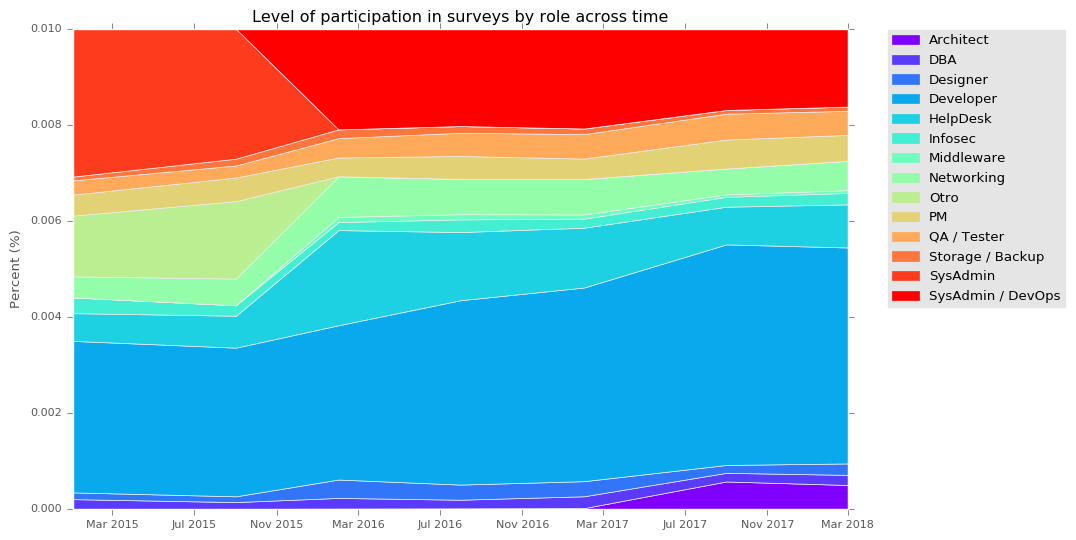


The results threw that Developers were from the beginning the majority group.  This is against the initial hypothesis, but not so falsy, neither the last conclusion:
1. It is clearly visible that the Developers group has grew through time starting on September 2015.
2. Helpdesk however, have decreased since February 2016.
3. "Storage / Backup" have falled and then dissapeared.
4. "Otro" (others) has been raising from the begining -then dissapeared-, but marked the tendency of the universe of samples which tends to diverge in respect to the role.
5. The rest of roles maintain some consistency over time.


In [40]:
import matplotlib.patches as mpatches

%matplotlib inline
plt.style.use(['classic', 'ggplot'])
plt.rcParams.update({'figure.figsize': (10.0, 6.0), 'font.size': 8})

trending_roles = np.unique(dfrt['role'])
roles_colors = cm.rainbow(np.linspace(0, 1, len(trending_roles)))
publish_dates = np.unique(dfrt['publish_date'])

y = []
for i, role in enumerate(trending_roles):
    role_y = []
    for j, date in enumerate(publish_dates):
        dfrs = dfrt.query('role == @role & publish_date == @date')
        count = 0 if len(dfrs['count']) == 0 else dfrs['count'].values[0]
        role_y.append(count)
    y.append(role_y)

# define data points for stackplot
x = publish_dates
y = np.row_stack(y)
percent = np.divide(y, y.sum(axis=0).astype(float) * 100)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.stackplot(x, percent, colors=roles_colors)
ax.set_title('Level of participation in surveys by role across time')
ax.set_ylabel('Percent (%)')

# creating the legend manually
plt.legend([mpatches.Patch(color=roles_colors[i]) for i, role in enumerate(trending_roles)],
           trending_roles, 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    
display(md('## Level of participation in surveys by role'))
display(md("""
This initial graph aims to help understanding who participated in the surveys on each period.

It is very important to understand the universe of samples, which may be a segment of the entire tech community in Argentina. There're reasons to think on this.
A valid one is that SysArmy may have started as group of sysadmins/security guys -mainly, perhaps due to the topics they post about-, then spreaded more to the devs community.

In order to prove this hypothesis, we graph the percentual level of participation by role (only top roles).
"""))
plt.show()
display(md("""
The results threw that Developers were from the beginning the majority group.  This is against the initial hypothesis, but not so falsy, neither the last conclusion:
1. It is clearly visible that the Developers group has grew through time starting on September 2015.
2. Helpdesk however, have decreased since February 2016.
3. "Storage / Backup" have falled and then dissapeared.
4. "Otro" (others) has been raising from the begining -then dissapeared-, but marked the tendency of the universe of samples which tends to diverge in respect to the role.
5. The rest of roles maintain some consistency over time.
"""))

## Histogram of Incomes by period (Argentina)

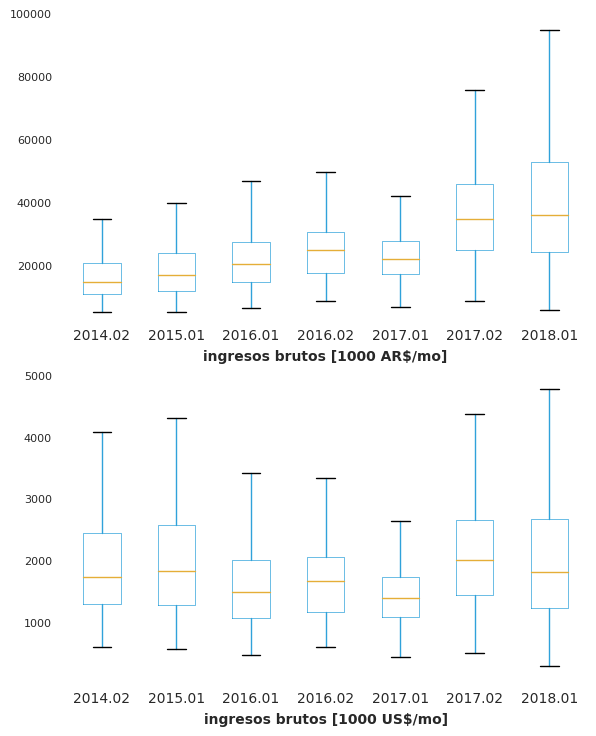

In [357]:
from math import log


# http://jonchar.net/notebooks/matplotlib-styling/
def stylize_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.set_tick_params(top='off', direction='out', width=0.25)
    ax.yaxis.set_tick_params(right='off', direction='out', width=0.25)


dfq = df.query('location == "Ciudad Autónoma de Buenos Aires"')

plt.rcParams.update({'figure.figsize': (6.0, 8.0), 'font.size': 8})
plt.style.use(['seaborn-white'])
plt.rcParams['axes.facecolor'] = '#ffffff'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

groups = dfq.groupby('period')
years = pd.DataFrame()
for name, group in groups:
    years[name] = group.salary

fig, ax = plt.subplots(2, 1)
stylize_axes(ax[0])
stylize_axes(ax[1])
ax[0].axis([0, 1, 4000, 100000])
ax[0].set_xlabel('ingresos brutos [1000 AR$/mo]')
years.boxplot(
    ax=ax[0],
    grid=False,
    boxprops=dict(linewidth=0.5, color='red'),
    whiskerprops=dict(linestyle='-', linewidth=1, color='yellow'),
    showfliers=False)
#fig.canvas.draw()

# en dólares y escala logarítmica
i = 0
years = pd.DataFrame()
ax[1].axis([0, 1, 100, 5000])
ax[1].set_xlabel('ingresos brutos [1000 US$/mo]')
for name, group in groups:
    years[name] = np.divide(group.salary, currencies[i])
    i+=1
years.boxplot(
    ax=ax[1],
    grid=False,
    boxprops=dict(linewidth=0.5, color='yellow'),
    whiskerprops=dict(linestyle='-', linewidth=1, color='yellow'),
    showfliers=False)
fig.canvas.draw()


## Density by range of salary


The following figures shows the density ranges of income for the Universe (Argentina samples) across time.
The histograms helps understand the probability density functions behind the data, which present some postive skew,
and a tendency to be shifted to the right through time (inflation adjustments).

It is also noticeable that the levels of dispersion increases since 2015, something that we will analyize next.


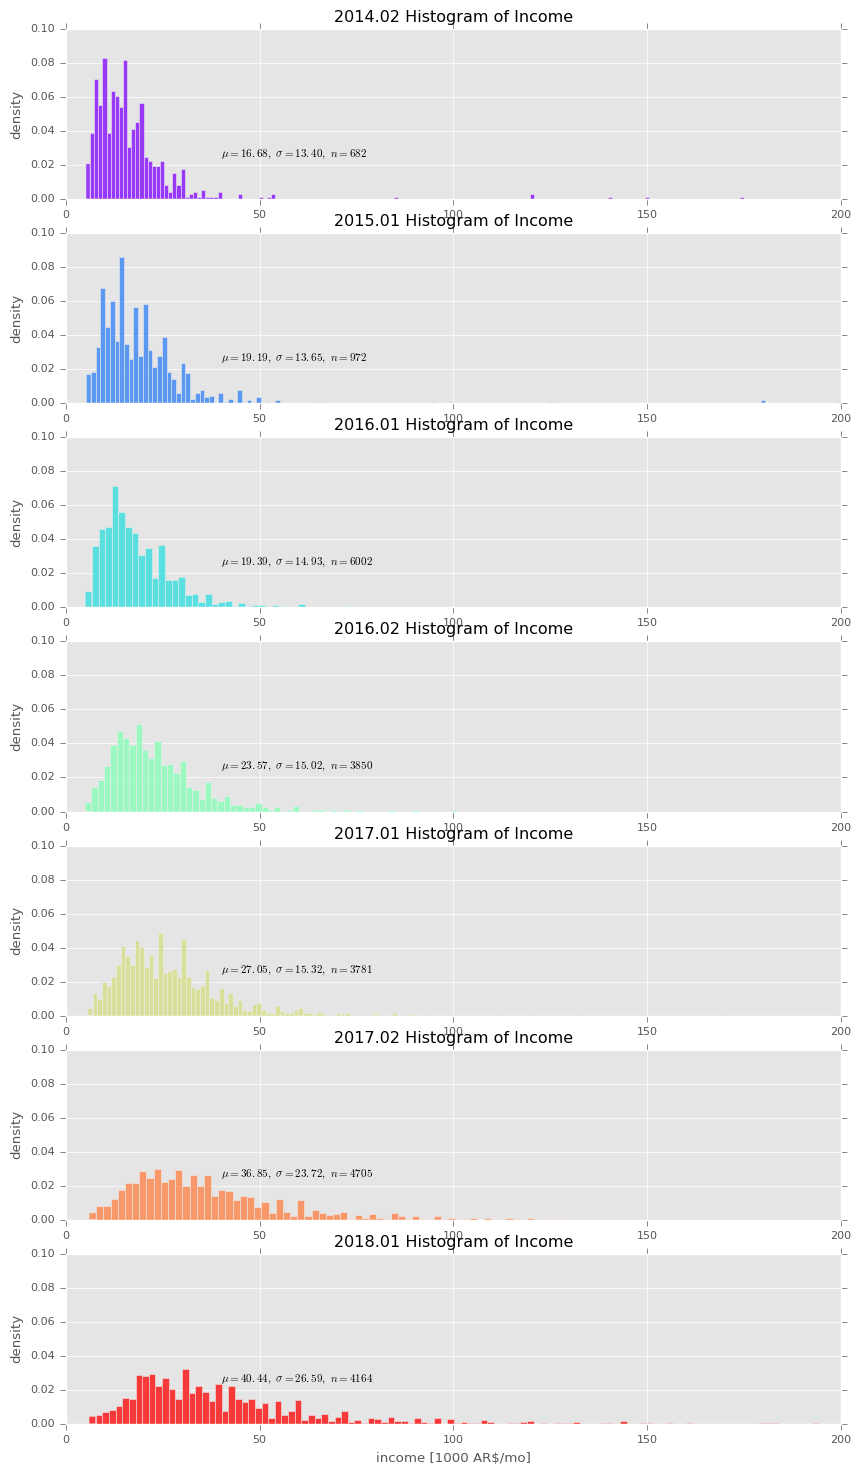

None

In [4]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': (10.0, 18.0), 'font.size': 8})
fig, ax = plt.subplots(len(periods), 1)
for i, period in enumerate(periods):
    dft = df[df['period'] == period]
    mu, sigma, t, d, m, s = getPlotSalarySeries(dft.salary)
    n, bins, patches = ax[i].hist(s, 160, normed=1, alpha=0.75, color=colors[i])
    ax[i].set_ylabel('density')
    ax[i].set_title(period + ' Histogram of Income')
    ax[i].text(40, .025, '$\mu=%.2f,\ \sigma=%.2f,\ n=%d$' % (mu, sigma, len(s)))
    ax[i].axis([0, 200, 0, 0.1])
    ax[i].grid(True)
ax[len(periods)-1].set_xlabel('income [1000 AR$/mo]')
fig.canvas.draw()

display(md('## Density by range of salary'))
display(md("""
The following figures shows the density ranges of income for the Universe (Argentina samples) across time.
The histograms helps understand the probability density functions behind the data, which present some postive skew,
and a tendency to be shifted to the right through time (inflation adjustments).

It is also noticeable that the levels of dispersion increases since 2015, something that we will analyize next.
"""))
display(plt.show())

## Mean and Standard deviation evolution

The following graph represents the income mean $\mu$ across time, along with the standard deviation $\sigma$.
This is an interesting time-series information, because describes better the raise in currency numbers (not purchasing power) of salaries.  The tendency is the growthness, which is for sure good, reflecting a correction over time of the numbers due to the inflation.

The next question would be, Are these corrections enough to at least maintain some stability on the purchasing levels?
To answer this, we may need information about levels of inflation.  As described in the Datasets section, there's no good data available of inflation in Argentina.  A workaround to help answer this question, from a different perspective, but a valid one, is to base the analysis on the dollar currency and see the evolution of income (cotinue reading).

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


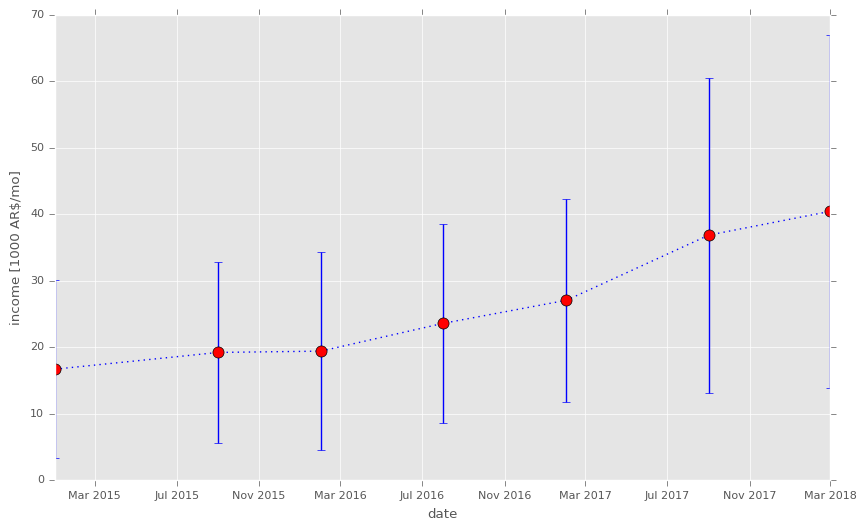

In [22]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': (10.0, 6.0), 'font.size': 8})
mus, sigmas, dates = [], [], []
for period in periods:
    dft = df[df['period'].str.contains(period)]
    mu, sigma, t, d, m, s = getPlotSalarySeries(dft.salary)
    mus.append(mu)
    sigmas.append(sigma)
    dates.append(np.max(dft['publish_date']))
    
#plt.plot(dates, mus, '+', label='$\mu$', ls='-', c='b')
#plt.plot(dates, sigmas, '+', label='$\sigma$', ls=':', c='g')
plt.errorbar(dates, mus, yerr=sigmas, fmt='', color='b', mfc='red', marker='o', markersize=8, linestyle='dotted')
plt.xlabel('date'); plt.ylabel('income [1000 AR$/mo]')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Currency evolution (Argentine Peso)

Continuing with the previous analysis, we obtained the data of AR\$ to US\$ over time, of the last 5 years.  The next step would be to sample from these series, only few points of reference for the periods that our surveys datasets correspond.

So we plot below, the peso evolution in green, and overlapped in blue, the sampled values of these series for the periods of our interest.

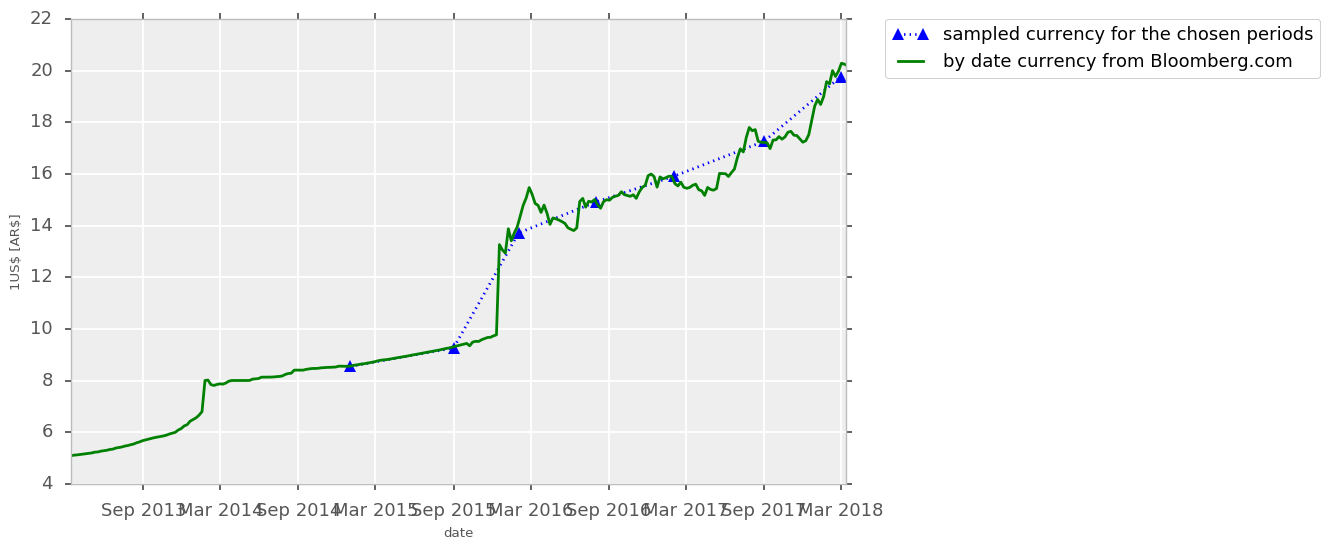

In [187]:
import json
import datetime
with open('../../data/usdars-cur.json') as data_file:    
    data = json.load(data_file)  
    df_currency = pd.DataFrame(data[0]['price'])
    df_currency.date = pd.to_datetime(df_currency.date)

%matplotlib inline
plt.rcParams.update({'figure.figsize': (10.0, 6.0), 'font.size': 8})
delta = datetime.timedelta(days=15)
currencies = []
for date in dates:
    currency_series = df_currency[(df_currency.date >= date-delta) & (df_currency.date <= date+delta)]
    currencies.append(float(currency_series.value[:1]))

plt.xlabel('date'); plt.ylabel('1US\$ [AR\$]')
plt.plot(dates, currencies, '+', label='sampled currency for the chosen periods', ls='dotted', c='b', marker='^')
plt.plot(df_currency.date, df_currency.value, label='by date currency from Bloomberg.com', ls='-', c='g')
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show()

## Monthly nominal GDP

Once obtained the peso value in dollar currency, we calculate the salaries mean $\mu$ over time, in dollars:
Monthly Gross Domestic Product, in US dollars, tell us the purchasing capacity of Argentines salaries in nominal values.  To compute the values, we just divide each $\mu$ in pesos by the dollar rate at its given moment.

$$
\sum_i{nom(GDP_i)} = \sum_i{\mu_i US\$} = \sum_i{\frac {\mu_i AR\$}{exchrate_i{\frac {AR\$}{US\$}}}}
$$

The results can be compared with World Bank data for Argentina provided here:

http://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD?end=2016&locations=AR&start=2010


### Evolution of mean income in AR$ (left), in US\$ (right)

As the figure show (left), the salary in pesos continuosly grows.
There's however, an interesting plateau in between the end of 2015 and beginning of 2016.
The two periods occurred before and after the Argentina presidential elections of October/December 2015.
It mustn't be coincidence that the numbers got practically freezed, perhaps due to the uncertainty caused by such national event.

There's another clear insight that we can identify on the figure at the right side.
Sadly the income in dollars falled down dramatically right after the elections.  This was due to the removal of the "cepo cambiario", 
which came along with a drastic devaluation of the local currency: http://www.bbc.com/mundo/noticias/2015/12/151217_argentina_fin_cepo_devaluacion_irm


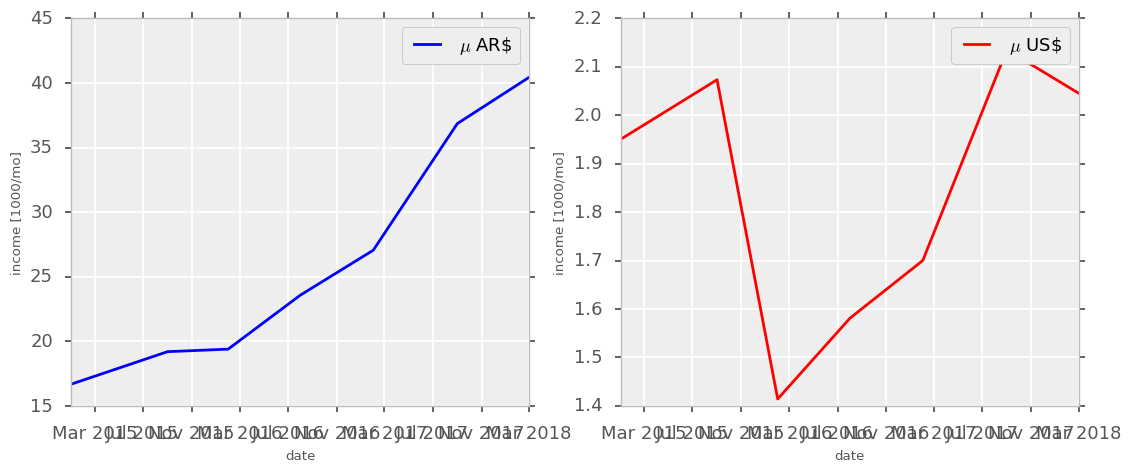

None

In [173]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': (13.0, 5.0), 'font.size': 8})

fig, ax = plt.subplots(1, 2)
ax[0].set_xlabel('date'); ax[0].set_ylabel('income [1000/mo]')
ax[0].plot(dates, mus, '+', label='$\mu$ AR\$', ls='-', c='b')
ax[0].legend()

ax[1].set_xlabel('date'); ax[1].set_ylabel('income [1000/mo]')
ax[1].plot(dates, np.divide(mus, currencies), '+', label='$\mu$ US\$', ls='-', c='r')
ax[1].legend()
fig.canvas.draw()

display(md("""
### Evolution of mean income in AR$ (left), in US\$ (right)

As the figure show (left), the salary in pesos continuosly grows.
There's however, an interesting plateau in between the end of 2015 and beginning of 2016.
The two periods occurred before and after the Argentina presidential elections of October/December 2015.
It mustn't be coincidence that the numbers got practically freezed, perhaps due to the uncertainty caused by such national event.

There's another clear insight that we can identify on the figure at the right side.
Sadly the income in dollars falled down dramatically right after the elections.  This was due to the removal of the "cepo cambiario", 
which came along with a drastic devaluation of the local currency: http://www.bbc.com/mundo/noticias/2015/12/151217_argentina_fin_cepo_devaluacion_irm
"""))
display(plt.show())

![](https://media.giphy.com/media/26BkO8zeNfyXvw2Xu/giphy.gif)

## Distribution of Income by period (Argentina)

### Assuming Normal distribution

Despite the fact that histograms throw distributions more similar to a $\gamma$ (Gamma) function, and the marked possitive skewness, for simplicity we will use the $N$ (Gaussian) distribution.

* Probability density function 
 
$$
\large
{\displaystyle f(x\;|\;\mu ,\sigma ^{2})={\frac {1}{\sqrt {2\pi \sigma ^{2}}}}\;e^{-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}}}
$$
 
* Gaussian density paramters 
 
$$
\large 
\begin{align} 
\mu &= \frac{1}{N} \sum_i x_i \\ 
\sigma^2 &= \frac{1}{N} \sum_i x_i^2 
\end{align} 
$$

The following figure, shows for the full dataset by period, the mean ($\mu$), and the standard deviation ($\sigma$).  It is noticieable the shifting to the right of the curves across time, indicating that salaries somehow followed the inflation tendency.

A new insight can be distinguished from this graph: the standard deviation of the salaries (the amplitude of the gaussian shape) starts increasing since 2016.  Once again, after the presidential elections, the course of the economy changed, and then the rules and behavior of salaries.
Here, an interpretation would be, that the tendency of incomes is now more sparse, meaning that for the same type of work and experience -in general- there's people with totally different salaries (wider ranges).

In [ ]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': (10.0, 6.0), 'font.size': 8})
plt.xlim(0,100)
for i, period in enumerate(periods):
    dft = df[df.period.str.contains(period)]
    mu, sigma, t, d, m, s = getPlotSalarySeries(dft.salary)
    plt.plot(t, sps.norm.pdf(t, mu, sigma), label=period + '\n$\mu=%.2f,\ \sigma=%.2f,\ n=%d$\n' % (mu, sigma, len(s)), ls='-', c=colors[i])
    plt.axvline(x=mu, ls=':', c=colors[i])
plt.xlabel('income [1000 AR$/mo]'); plt.ylabel('density, $N$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Interactive dynamic dashboard

The next figure is dynamic. It has some controls that lets you to filter data and so, refresh the visualization comparing diferent dimensionality reductions, with the average by dataset, using the probability denstiy functions as curve.

_NOTE: in order to make this work, you may need to run this notebook locally, using Jupyter Notebooks_

In [ ]:
from IPython.display import clear_output
import ipywidgets as widgets

filters = ['role', 'yoe', 'yip', 'location', 'age']
i_filters = [{'name': r, 'i': i} for i, r in enumerate(filters)]
filters_opts = list(map(lambda r: list(df[r].unique()), filters))
filters_checkboxes = list(map(lambda r: widgets.Checkbox(value=False, description='Use '+r, name='use_'+r, disabled=False), filters))
filters_dropdowns = list(map(lambda r: widgets.Dropdown(options=filters_opts[r['i']], value=filters_opts[r['i']][0], name=r['name'], description=r['name']+':', disabled=not filters_checkboxes[r['i']].value), i_filters))

%matplotlib notebook
plt.rcParams.update({'figure.figsize': (13.0, 6.0), 'font.size': 8})
fig, ax = plt.subplots()
ax.set_xlim(-20,100)
ax.set_ylim(0,0.08)
ax.set_xlabel('income [1000 AR$/mo]'); ax.set_ylabel('density, $N$')

def on_filters_change(change):
    for i in range(len(filters)):
        checkbox = filters_checkboxes[i]
        dropdown = filters_dropdowns[i]
        if change['owner'].name == checkbox.name:
            dropdown.disabled = not change['new']
            break
    plot_filtered_monthly_income()

def plot_filtered_monthly_income(change = None):
    plt.rcParams.update({'figure.figsize': (10.0, 8.0), 'font.size': 8})
    if not ax.lines:
        for i, period in enumerate(periods):
            dft = df[df.period.str.contains(period)]
            mu, sigma, t, d, m, s = getPlotSalarySeries(dft.salary)            
            ax.plot(t, sps.norm.pdf(t, mu, sigma), label=period, ls=':', c=colors[i])
            ax.plot(t, sps.norm.pdf(t, mu, sigma), label=period + ' $\mu=%.2f,\ \sigma=%.2f,\ n=%d$' % (mu, sigma, len(s)), ls='-', c=colors[i])
    else:
        for i, period in enumerate(periods):
            dft = df[df.period.str.contains(period)]
            for dropdown in filters_dropdowns:
                dft = dft if dropdown.disabled else dft[dft[dropdown.name].str.contains(dropdown.value)]
            mu, sigma, t, d, m, s = getPlotSalarySeries(dft.salary)
            line = ax.lines[2*i+1]
            if len(dft) > 2:
                line.set_xdata(t)
                line.set_ydata(sps.norm.pdf(t, mu, sigma))
                line.set_label(period + ' $\mu=%.2f,\ \sigma=%.2f,\ n=%d$' % (mu, sigma, len(s)))
            else:
                line.set_xdata([]), line.set_ydata([])
    title = 'Segment:' + ''.join([
        '' if dropdown.disabled else ' %s: %s' % (dropdown.name, dropdown.value)
            for dropdown in filters_dropdowns])
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
    ax.grid(True)
    fig.canvas.draw()
    plt.ion()
    plt.show()

boxes = []
for i in range(len(filters_dropdowns)):
    filters_checkboxes[i].observe(on_filters_change, names='value')
    filters_dropdowns[i].observe(plot_filtered_monthly_income, names='value')
    boxes.append(widgets.Box([filters_checkboxes[i], filters_dropdowns[i]]))

display(widgets.Box(boxes))
plot_filtered_monthly_income()

## Comparative analysis by technology

Below, we will rank technologies by most frequent.  We will exclude technologies with less than 100 samples in total -because they are in most cases, isolated, and doesn't follow clear trends.

From the resulting table we will plot the results in two ways:

1. First as a time-series comparative of the technologies by period, indicatin the $\mu$ mean salary.
2. Secondly, as a scatter, having the salary mean $\mu$ in the X axis, the standard deviation $\sigma$ in the Y axis and the amount of samples as the size of the dot.

In [ ]:
dfst = pd.DataFrame(columns=['stack', 'count', 'mu', 'sigma', 'period', 'publish_date'])

i = 0
for period in periods:
    for j, row in dfs.iterrows():
        dfss = df.loc[ row['df_mask'] & (df['period'] == period) ]
        if len(dfss) == 0: continue
        mu, sigma, t, d, m, s = getPlotSalarySeries(dfss['salary'])
        dfst.loc[i] = [row['stack'], len(dfss), mu, sigma, period, np.max(dfss['publish_date'])]
        i = i+1

# the ranking of technologies most frequent in the datasets order by mean of salary
dfst = dfst.query('count >= 1').sort_values(by=['stack', 'period'], ascending=[0, 0])
display(md('## Top stacks: numbers by period'))
dfst.head()

In [ ]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': (10.0, 6.0), 'font.size': 8})

trending_stacks = np.unique(dfst['stack'])
stacks_colors = cm.rainbow(np.linspace(0, 1, len(trending_stacks)))
for i, stack in enumerate(trending_stacks):
    dfp = dfst.query('stack == @stack')
    plt.plot(dfp['publish_date'], dfp['mu'], '+', label='$\mu$ AR\$ %s' % stack, ls='-', c=stacks_colors[i])
    plt.xlabel('date'); plt.ylabel('$\mu$')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
display(md('## Mean salary of the most frequent technologies (stacks) through time'))

In [ ]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': (13.0, 30.0), 'font.size': 10})

fig, ax = plt.subplots(len(periods), 1)
for i, period in enumerate(periods):
    ## plot only the top ranked technologies in terms of salary for the period sample
    dftss = dfst.query("@period == period").sort_values(by=['mu', 'sigma'], ascending=[0, 0])[:30]
    ax[i].scatter(
        dftss['sigma'], dftss['mu'], marker='o', c=dftss.index, s=100*dftss['count']**(1/2), alpha=0.3,
        cmap=plt.get_cmap('Spectral'))

    for label, x, y in zip(dftss['stack'], dftss['sigma'], dftss['mu']):
        ax[i].annotate(
            label,
            xy=(x, y), xytext=(30, -30),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

    ax[i].set_xlabel('$\mu$'); ax[i].set_ylabel('$\sigma$')
    ax[i].set_title('%s - Technologies by salary, standard deviation and num of samples.' % period)
    fig.canvas.draw()
display(md('## Scatter of technologies by mean, dispersion, frequency and time'))
display(md('_NOTE: It\'s pending for these results to drive some conclusion (WIP)._'))
display(md('_NOTE: The circles radius represents the frequency (number of entries) by stack in an inversely cuadratic representation._'))